# Virtual Concierge

## Host pre-trained endpoint for MXNET model

In this notebook we will download a pre-trained MXNET model and deploy endpoint

In [ ]:
# Download pre-trained model if haven't already created from previous notebook
import os

if not os.path.exists('model.tar.gz'):
    !aws s3 cp s3://deeplens-virtual-concierge-model/mobilefacenet/model.tar.gz .

### Import model into SageMaker

Open a new sagemaker session and upload the model on to the default S3 bucket. We can use the ``sagemaker.Session.upload_data`` method to do this. We need the location of where we exported the model from MXNet and where in our default bucket we want to store the model(``/model``). The default S3 bucket can be found using the ``sagemaker.Session.default_bucket`` method.

In [ ]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [ ]:
model_data = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='virtual-concierge')

Use the ``sagemaker.mxnet.model.MXNetModel`` to import the model into SageMaker that can be deployed. We need the location of the S3 bucket where we have the model, the role for authentication and the entry_point where the model defintion is stored (``predict.py``). 

In [ ]:
from sagemaker.mxnet.model import MXNetModel
sagemaker_model = MXNetModel(model_data=model_data, role=role, entry_point='predict.py',
                             py_version='py3', framework_version='1.3.0',
                             sagemaker_session=sagemaker_session) # require session

### Create Transformer for an existing model

Create a transform and from this model.

In [ ]:
transformer = sagemaker_model.transformer(instance_count=1, instance_type='ml.m4.xlarge')

## Load sample image

Load s ample image from s3 and render faces

In [2]:
import boto3
import json
import io
import PIL.Image, PIL.ImageDraw

rekognition = boto3.client('rekognition')

def get_bboxes(image):
    # Save the image as bytes
    imageBytes = io.BytesIO()
    image.save(imageBytes, format='PNG')
    # Detect faces
    ret = rekognition.detect_faces(
        Image={
            'Bytes': imageBytes.getvalue()
        },
        Attributes=['DEFAULT'],
    )
    # Return the bounding boxes for each face
    width, height = image.size
    bboxes = []
    for face in ret['FaceDetails']:
        box = face['BoundingBox']
        x1 = int(box['Left'] * width)
        y1 = int(box['Top'] * height)
        x2 = int(box['Left'] * width + box['Width'] * width)
        y2 = int(box['Top'] * height + box['Height']  * height)
        bboxes.append((x1, y1, x2, y2))
    return bboxes

In [3]:
s3 = boto3.resource('s3')

# Read image from s3
image = {
    'S3Object': {
        'Bucket': 'aiml-lab-sagemaker',
        'Name': 'politicians/politicians1.jpg'
    }
}
image_object = s3.Object(image['S3Object']['Bucket'] , image['S3Object']['Name'])
payload = image_object.get()['Body'].read()

For each of the coordinates, get a the aligned image, and draw the rectangle

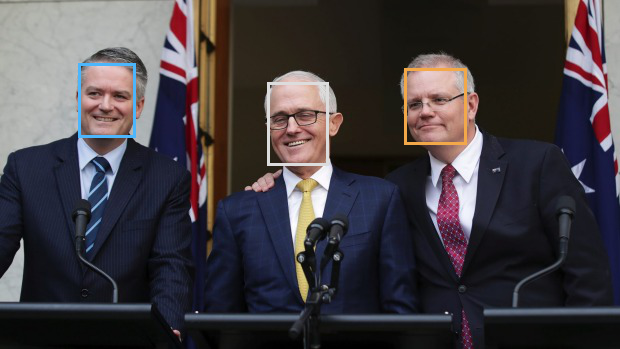

In [4]:
# Load the image and get boxes
f = io.BytesIO(payload)
image = PIL.Image.open(f).convert('RGB')
boxes = get_bboxes(image)

# blue, green, red, grey
colors = ((220,220,220),(242,168,73),(76,182,252),(52,194,123))

# Draw rectangles on image
draw = PIL.ImageDraw.Draw(image)
for col, bbox in enumerate(boxes): 
    draw.rectangle(bbox, outline=colors[col%4], width=3)

image

## Create transform input

Save the images to a transform folder and upload to S3

In [ ]:
!rm -Rf transform
!mkdir -p transform

In [7]:
%%time

import base64

rekognition = boto3.client('rekognition')
    
# Call rekognition to get bbox
ret = rekognition.detect_faces(
    Image={
        'Bytes': payload
    },
    Attributes=['DEFAULT'],
)

# Save a series of json files for each boundary box and roll
for i, face in enumerate(ret['FaceDetails']):
    event = { 
        'Image': { 'Bytes': str(base64.b64encode(payload), 'utf-8') },
        'BoundingBox': face['BoundingBox'],
        'Roll': round(face['Pose']['Roll']/90)*90,
    }
    filename = 'transform/{}.json'.format(i)
    with open(filename, 'w') as f:
        print('saving: {}'.format(filename))
        json.dump(event, f)

saving: transform/0.json
saving: transform/1.json
saving: transform/2.json
CPU times: user 19.7 ms, sys: 50 µs, total: 19.7 ms
Wall time: 802 ms


In [ ]:
# Save the numpy image to s3 for batch transform
image_data = sagemaker_session.upload_data(path='transform', key_prefix='virtual-concierge/transform')
!aws s3 ls $image_data/

Run the transform process on this file

In [ ]:
transformer.accept = 'application/json'
transformer.transform(image_data, content_type='application/json', split_type='Line')
transformer.wait()

In [ ]:
# TODO: Load the file back from s3 to read the results

## Clean up

Tear down the sagemaker model

In [ ]:
sagemaker_model.delete_model()

In [ ]:
import shutil

shutil.rmtree('transform')
os.remove('model.tar.gz')
shutil.rmtree('model')